## Предсказание траекторий автомобилей

In [2]:
!python -V

Python 3.8.16


In [3]:
from platform import python_version

print(python_version())
print('hi')

3.8.16
hi


In [4]:
from IPython.display import Video

In [5]:
Video("motion-prediction-video.mp4", width=400, height=400)

## Соревнование https://research.yandex.com/shifts/vehicle-motion-prediction

Трек по предсказанию траекторий движения автомобилей. Соревнование в целом посвящено исследованию подходов к оценке неопределенности и устойчивости моделей к сдвигам во входных данных.

![Ансамбль моделей](uncertainty.jpeg)

## Что представляют из себя данные

Единицей данных в датасете является сцена. Сцена содержит в себе информацию о динамических объектах (автомобилях и пешеходах), векторную карту дорожного графа, состояния светофоров, теги для сцены и отдельных агентов.

Данные в сцене разбиты на две зоны: прошлое и будущее. Для каждого автомобиля нам известны следующие параметры:
- уникальный идентификатор
- положение в глобальной системе координат
- размеры
- скорость
- ускорение

Аналогичные данные известны для самого беспилотника. Для пешехедов данные ограничиваются id, положением, размером и скоростью.

Дорожный граф содержит в себе информацию о полосах, полигон дороги, полигоны пешеходных переходов.

Ссылка на тест сет, с которым поработаем на семинаре: https://disk.yandex.ru/d/M_4ED0r19OnSrg

## API для работы с датасетом

Рекомендую установить в virtualenv, чтобы не ставить лишние пакеты в хостовую систему.
```
git clone git@github.com:yandex-research/shifts.git
cd shifts/sdc
pip install .
```

## Посмотрим на данные

Исходные сырые данные хранятся в формате protubuf (https://developers.google.com/protocol-buffers), он позволяет удобно хранить и рабоать со структурированными объектами.

In [6]:
from ysdc_dataset_api.utils import read_scene_from_file

/home/techtoker/tools/anaconda3/envs/yandex_sdc/lib/python3.8/site-packages/ysdc_dataset_api/utils/transform.py:90: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  res = transform @ ph
/home/techtoker/tools/anaconda3/envs/yandex_sdc/lib/python3.8/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


In [7]:
scene = read_scene_from_file('../datasets/canonical-eval-data/011/011000.pb')

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/canonical-eval-data/011/011000.pb'

In [ ]:
scene.path_graph

In [8]:
print(f'Тип объекта: {type(scene)}')
print(f'Поля объекта: {[field for field in dir(scene) if not field.startswith("_") and field.islower()]}')

NameError: name 'scene' is not defined

Каждая сцена содержит в себе данные о прошлом и будущем на 5 секунд (всего 10 секунд). Это время разбито на 50 дискретных таймстемпов с частотой  5Hz.

In [9]:
print(f'Горизонт прошлого: {len(scene.past_vehicle_tracks)}, горизонт будущего: {len(scene.future_vehicle_tracks)}')

NameError: name 'scene' is not defined

Индекс 0 в past_tracks соответсвтует -5 секундам в истории, индекс 24 -- нулевая секунда, момент предсказния.

In [11]:
print(f'Количество машин в момент предсказания: {len(scene.past_vehicle_tracks[-1].tracks)}')
print('Информация об одной из машин в момент предсказания:')
print(scene.past_vehicle_tracks[-1].tracks[0])

Количество машин в момент предсказания: 17
Информация об одной из машин в момент предсказания:
track_id: 34169
position {
  x: 3528.887235455813
  y: -1845.6880594767722
  z: 0.8689320729550655
}
dimensions {
  x: 4.390752201556174
  y: 2.0034280269183236
  z: 1.7411829130317864
}
linear_velocity {
  x: 0.08383738883850562
  y: -0.03237506137534246
}
linear_acceleration {
  x: 0.14328786721880105
  y: -0.023524992679709048
}
yaw: -0.20406750287213143



В сцене есть поле `prediction_requests` содержащее id автомобилей, для которых необходимо сделать предсказание. Помимо этого реквесты помечены тегами, описывающими характер движения автомобиля. Полный список тегов можно найти в файле `tags.proto` [ссылка](https://github.com/yandex-research/shifts/blob/main/sdc/ysdc_dataset_api/proto/tags.proto)

In [12]:
for r in scene.prediction_requests:
    if r.track_id == scene.past_vehicle_tracks[-1].tracks[0].track_id:
        print(r)

track_id: 34169
trajectory_tags: kStationary
trajectory_tags: kUniform



Тэги есть так же и у сцен. Они описывают различные срезы данных, по которым проходило разбиение в соревновании.

In [13]:
print(scene.scene_tags)

day_time: kAfternoon
season: kAutumn
track: Moscow
sun_phase: kDaylight
precipitation: kNoPrecipitation



Давайте нарисуем уже сцену и посмотрим, как оно выглядит не в скучных числах.

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
from matplotlib import collections as mc

from ysdc_dataset_api.dataset import MotionPredictionDataset
from ysdc_dataset_api.features import FeatureRenderer
from ysdc_dataset_api.utils import transform_2d_points

In [148]:
with open('renderer_config.yaml') as f:
    renderer_config = yaml.safe_load(f)

In [149]:
import ysdc_dataset_api.features

print(ysdc_dataset_api.features.__file__)

/home/techtoker/tools/anaconda3/envs/yandex_sdc/lib/python3.8/site-packages/ysdc_dataset_api/features/__init__.py


In [150]:
renderer = FeatureRenderer(renderer_config)

In [151]:
dataset_path = '../dataset/development_pb/'

In [152]:
dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    feature_producers=[renderer],
    transform_ground_truth_to_agent_frame=True)

In [153]:
print(f'Количество сцен в датасете: {dataset.num_scenes}')

Количество сцен в датасете: 36605


In [154]:
# dataset_iter = iter(dataset)
#
# # Проитерируемся по датасету в поисках машины, проехавшей более 2 метров по одной из координат.
# while True:
#     data_item = next(dataset_iter)
#     if data_item['ground_truth_trajectory'][-1, 0] > 2.0 or data_item['ground_truth_trajectory'][-1, 1] > 2.0:
#
#         if data_item['scene_tags']['track'] == 'Innopolis':
#             # print(data_item)
#
#             break

In [155]:
# idx = 0
# real_idx = 0
#
# dataset_iter = iter(dataset)
#
# while True:
#     data_item = next(dataset_iter)
#     real_idx += 1
#
#     if data_item['scene_tags']['track'] == 'Innopolis':
#         idx += 1
#
#         # if idx < 370:
#         #     continue
#         #
#         # if idx > 400:
#         #     break
#
#         # Plot vehicles occupancy, pedestrian occupancy, lane occupancy and road polygon
#         plt.figure(figsize=(10, 10))
#         plt.imshow(data_item['feature_maps'][0], origin='lower', cmap='binary', alpha=0.7)
#         plt.imshow(data_item['feature_maps'][6], origin='lower', cmap='binary', alpha=0.5)
#         plt.imshow(data_item['feature_maps'][13], origin='lower', cmap='binary', alpha=0.2)
#         plt.imshow(data_item['feature_maps'][16], origin='lower', cmap='binary', alpha=0.1)
#
#         # Переведем ground truth траекторию агента в систему координат фичемапы
#         transformed_gt = transform_2d_points(data_item['ground_truth_trajectory'], renderer.to_feature_map_tf)
#         transformed_gt = np.round(transformed_gt - 0.5).astype(np.int32)
#
#         ax = plt.gca()
#         ax.add_collection(mc.LineCollection([transformed_gt], color='green'))
#         plt.savefig(f'./samples/res_{idx}.png')
#
#     print(real_idx)

In [156]:
innopolis_scenes = []

#dataset_iter = iter(dataset)

for d_item in dataset:

    if d_item['ground_truth_trajectory'][-1, 0] > 2.0 or d_item['ground_truth_trajectory'][-1, 1] > 2.0:

        if d_item['scene_id'] == 'abbfe977229cd8f605de977495eee9f4':
        #if d_item['scene_tags']['track'] == 'Innopolis':
            innopolis_scenes.append(d_item)

            print(len(innopolis_scenes))

            if len(innopolis_scenes) == 2:
                break

1
2


In [157]:
len(innopolis_scenes)
data_item = innopolis_scenes[0]

In [158]:
#data_item = dataset[0] #innopolis_scenes[44]

In [159]:
print(f'Датасет для каждого объекта возвращает набор следующих полей: {[k for k in data_item.keys()]}')

Датасет для каждого объекта возвращает набор следующих полей: ['scene_id', 'track_id', 'scene_tags', 'ground_truth_trajectory', 'feature_maps']


In [160]:
print(f'Размеры фичемап, которые нам отдал рендерер: {data_item["feature_maps"].shape}')

Размеры фичемап, которые нам отдал рендерер: (17, 128, 128)


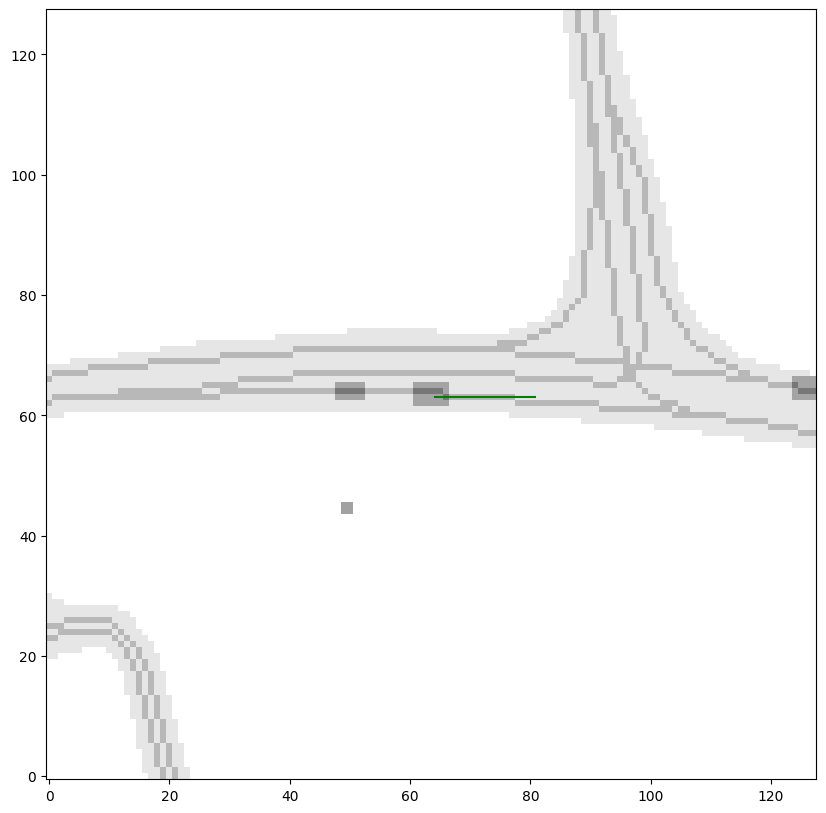

In [161]:
# Plot vehicles occupancy, pedestrian occupancy, lane occupancy and road polygon
plt.figure(figsize=(10, 10))
plt.imshow(data_item['feature_maps'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(data_item['feature_maps'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(data_item['feature_maps'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(data_item['feature_maps'][16], origin='lower', cmap='binary', alpha=0.1)

# Переведем ground truth траекторию агента в систему координат фичемапы
transformed_gt = transform_2d_points(data_item['ground_truth_trajectory'], renderer.to_feature_map_tf)
transformed_gt = np.round(transformed_gt - 0.5).astype(np.int32)

ax = plt.gca()
ax.add_collection(mc.LineCollection([transformed_gt], color='green'))
plt.savefig('res.png')

In [116]:
transformed_gt

array([[252, 249],
       [254, 249],
       [257, 249],
       [259, 249],
       [261, 249],
       [263, 249],
       [265, 249],
       [267, 249],
       [270, 249],
       [272, 249],
       [274, 249],
       [276, 249],
       [278, 249],
       [280, 249],
       [283, 249],
       [286, 248],
       [289, 248],
       [292, 248],
       [296, 248],
       [299, 248],
       [303, 247],
       [307, 247],
       [311, 247],
       [316, 246],
       [320, 246]], dtype=int32)

## Метрики

Одними из общепринятых метрик для оценки качества предсказания траекторий являются Average Displacement Error и Final Displacement Error, а так же их модификации minADE@k, minFDE@k:
- ADE - среднее по таймстемпам L2 отклонеие предсказания от ground truth
- FDE - L2 отклонение последней предсказанной точки траектории от ground truth
- minADE@k -- минимальное значение ADE по k наиболее вероятных предсказанных гипотез
- minFDE@k -- минимальное значение FDE по k наиболее вероятных предсказанных гипотез

In [ ]:
def ade(y_true, y_pred):
    """
    Insert your code for ADE computation below.
    
    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """

In [ ]:
def fde(y_true, y_pred):
    """
    Insert your code for FDE computation below.
    
    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """

In [ ]:
def min_ade(y_true, y_pred):
    """
    Insert your code for minADE computation below.
    
    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_modes, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """

In [ ]:
def min_fde(y_true, y_pred):
    """
    Insert your code for minFDE computation below.
    
    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_modes, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """

## Модель с константным предсказанием

In [144]:
import torch
import tqdm

from ysdc_dataset_api.features import FeatureVectorizer

In [145]:
class BaselineModel(torch.nn.Module):
    def __init__(self, gt_time_grid):
        super().__init__()
        self._gt_time_grid = torch.tensor(gt_time_grid)
    
    def forward(self, velocity):
        states = torch.einsum('bc,t->btc', velocity, self._gt_time_grid)
        return states

In [146]:
model = BaselineModel(np.linspace(0.2, 5, 25))

In [148]:
with open('vectorizer_config.yaml') as f:
    vectorizer_config = yaml.safe_load(f)
vectorizer = FeatureVectorizer(vectorizer_config)

dataset = MotionPredictionDataset(
    dataset_path='./test/',
    prerendered_dataset_path='./test/',
    feature_producers=[vectorizer],
    transform_ground_truth_to_agent_frame=True,
)

In [149]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    num_workers=8,
)

In [150]:
ades = []
fdes = []
for batch in tqdm.tqdm(dataloader):
    # Возьмём скорость по (x, y) в последний известный момент времени
    predictions = model(batch['vector_features'][:, -1, 2:4])
    ades.append(ade(batch['ground_truth_trajectory'], predictions))
    fdes.append(fde(batch['ground_truth_trajectory'], predictions))

0it [00:00, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021FFEC19160>
Traceback (most recent call last):
  File "C:\Users\impor\.anaconda3\envs\yandex_sdc\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\impor\.anaconda3\envs\yandex_sdc\lib\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\impor\.anaconda3\envs\yandex_sdc\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\impor\.anaconda3\envs\yandex_sdc\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
0it [00:21, ?it/s]


NameError: name 'ade' is not defined

In [ ]:
np.mean(np.concatenate(ades)), np.mean(np.concatenate(fdes))

## Визуализация предсказаний

In [12]:
# Тк в датасете выше мы использовали готовые пре-рендеренные картинки (см prerendered_dataset_path),
# сделаем себе соответсвующий рендерер, чтобы извлечь из него трансформ для визуализации.
with open('prerendered_images_config.yaml') as f:
    renderer_config = yaml.safe_load(f)
renderer = FeatureRenderer(renderer_config)


# Plot vehicles occupancy, pedestrian occupancy, lane occupancy and road polygon
i = 1
plt.figure(figsize=(10, 10))
plt.imshow(batch['prerendered_feature_map'][i][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(batch['prerendered_feature_map'][i][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(batch['prerendered_feature_map'][i][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(batch['prerendered_feature_map'][i][16], origin='lower', cmap='binary', alpha=0.1)

# Переведем ground truth траекторию агента в систему координат фичемапы
transformed_gt = transform_2d_points(batch['ground_truth_trajectory'][i].numpy(), renderer.to_feature_map_tf)
transformed_gt = np.round(transformed_gt - 0.5).astype(np.int32)

ax = plt.gca()
ax.add_collection(mc.LineCollection([transformed_gt], color='green'))

prediction = predictions[i].numpy().astype(np.float32)
transformed_prediction = transform_2d_points(prediction, renderer.to_feature_map_tf)
ax.add_collection(mc.LineCollection([transformed_prediction], color='red'))

NameError: name 'batch' is not defined

<Figure size 1000x1000 with 0 Axes>

## Мультимодальность

## Задание

В качестве задания предлагается обучить нейросетку для предсказания траекторий и побить наш бейзлайн.
Ссылки на данные:
- [трейн](https://disk.yandex.ru/d/tuTwRSLL-KFqjg)
- [валидация](https://disk.yandex.ru/d/3Lu6_6BgwkXlgw)
- [тест](https://disk.yandex.ru/d/M_4ED0r19OnSrg)

В своей реализации вы можете использовать векторные фичи для объекта, а так же растровые картинки.


Критерии оценки (subject to change):
- сделать нейросетку, которая бьёт бейзлайн (4 балла)
- использовать картиночные фичи (4 балла)
- научить сеть предсказывать более одной моды (2 балла)

In [ ]:
# Для использования картиночных фичей можно использовать уже нарендеренные картинки (они есть в датасете).
# Рендерить с нуля может быть довольно долго.
# Пример использования готовых картинок в датасете:

# dataset = MotionPredictionDataset(
#     dataset_path='/Users/gerrok/test/',
#     prerendered_dataset_path='/Users/gerrok/test/',  # Тут мы указываем путь, где искать готовые картинки
#     feature_producers=[vectorizer],
#     transform_ground_truth_to_agent_frame=True,
# )